# Effect Size

## Question: Are Men Taller Than Women? 

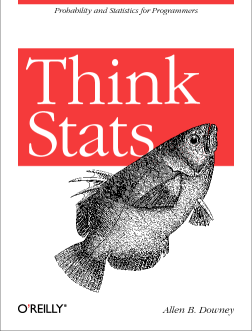

In [1]:
from IPython.display import Image
Image('http://greenteapress.com/thinkstats/think_stats_comp.png')

In [1]:
from __future__ import print_function, division

import numpy
import scipy.stats

import matplotlib.pyplot as pyplot

from IPython.html.widgets import interact, fixed
from IPython.html import widgets

# seed the random number generator so we all get the same results
numpy.random.seed(17)

# some nice colors from http://colorbrewer2.org/
COLOR1 = '#7fc97f'
COLOR2 = '#beaed4'
COLOR3 = '#fdc086'
COLOR4 = '#ffff99'
COLOR5 = '#386cb0'

%matplotlib inline

/Users/lr/anaconda2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


To explore statistics that quantify effect size, we'll look at the difference in height between men and women. 

I'll use `scipy.stats.norm` to represent the distributions.  

The result is an `rv` object (which stands for random variable).

In [2]:
mu1, sig1 = 178, 7.7
male_height = scipy.stats.norm(mu1, sig1)

In [3]:
male_height

In [4]:
mu2, sig2 = 163, 7.3
female_height = scipy.stats.norm(mu2, sig2)

In [5]:
female_height

The following function evaluates the normal (Gaussian) probability density function (PDF) within 4 standard deviations of the mean.  It takes and rv object and returns a pair of NumPy arrays.

In [6]:
def eval_pdf(rv, num=4):
    mean, std = rv.mean(), rv.std()
    xs = numpy.linspace(mean - num*std, mean + num*std, 100)
    ys = rv.pdf(xs)
    return xs, ys

Here's what the two distributions look like.

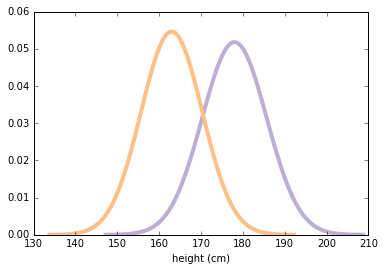

In [7]:
xs, ys = eval_pdf(male_height)
pyplot.plot(xs, ys, label='male', linewidth=4, color=COLOR2)

xs, ys = eval_pdf(female_height)
pyplot.plot(xs, ys, label='female', linewidth=4, color=COLOR3)
pyplot.xlabel('height (cm)');

Let's assume for now that those are the true distributions for the population.  

> Of course, in real life we never observe the true population distribution.  We generally have to work with a random sample.

I'll use `rvs` to generate random samples from the population distributions.  Note that these are totally random, totally representative samples, with no measurement error!

In [8]:
male_sample = male_height.rvs(1000)
female_sample = female_height.rvs(1000)

Both samples are NumPy arrays.  Now we can compute sample statistics like the mean and standard deviation.

In [10]:
mean1, std1 = male_sample.mean(), male_sample.std()
mean1, std1

(178.16511665818112, 7.8419961712899502)

The sample mean is close to the population mean, but not exact, as expected.

In [11]:
mean2, std2 = female_sample.mean(), female_sample.std()
mean2, std2

(163.48610226651135, 7.382384919896662)

And the results are similar for the female sample.

Now, there are many ways to describe the magnitude of the difference between these distributions.  An obvious one is the difference in the means:

In [11]:
difference_in_means = male_sample.mean() - female_sample.mean()
difference_in_means # in cm

14.679014391669767

On average, men are 14--15 centimeters taller.  For some applications, that would be a good way to describe the difference, but there are a few problems:

* Without knowing more about the distributions (like the standard deviations) it's hard to interpret whether a difference like 15 cm is a lot or not.

* The magnitude of the difference depends on the units of measure, making it hard to compare across different studies.

There are a number of ways to quantify the difference between distributions.  A simple option is to express the difference as a percentage of the mean.


In [12]:
# Exercise: what is the relative difference in means, expressed as a percentage?

relative_difference = difference_in_means / male_sample.mean()
relative_difference * 100   # percent

8.2389946286916569

But a problem with relative differences is that you have to choose which mean to express them relative to.

In [16]:
relative_difference = difference_in_means / female_sample.mean()
relative_difference * 100    # percent

8.9787536605040401

Part Two
========

An alternative way to express the difference between distributions is to see how much they overlap.  

- To define overlap, we choose a threshold between the two means.  The simple threshold is the midpoint between the means:

In [12]:
simple_thresh = (mean1 + mean2) / 2
simple_thresh

170.82560946234622

A better, but slightly more complicated threshold is the place where the PDFs cross.

In [13]:
thresh = (std1 * mean2 + std2 * mean1) / (std1 + std2)
thresh

170.6040359174722

In this example, there's not much difference between the two thresholds.

Now we can count how many men are below the threshold:

In [14]:
male_below_thresh = sum(male_sample < thresh)
male_below_thresh

164

And how many women are above it:

In [15]:
female_above_thresh = sum(female_sample > thresh)
female_above_thresh

174

The "overlap" is the total area under the curves that ends up on the wrong side of the threshold.

In [16]:
overlap = male_below_thresh / len(male_sample) + female_above_thresh / len(female_sample)
overlap

0.33799999999999997

Or in more practical terms, you might report the fraction of people who would be misclassified if you tried to use height to guess sex:

In [17]:
misclassification_rate = overlap / 2
misclassification_rate

0.16899999999999998

---

Another way to quantify the difference between distributions is what's called 

## "probability of superiority",

which is a problematic term, but in this context it's the probability that a randomly-chosen man is taller than a randomly-chosen woman.

In [24]:
# Exercise: suppose I choose a man and a woman at random.
# What is the probability that the man is taller?
sum(x > y for x, y in zip(male_sample, female_sample)) / len(male_sample)

0.91100000000000003

Overlap (or misclassification rate) and "probability of superiority" have two good properties:

* As probabilities, they don't depend on units of measure, so they are comparable between studies.

* They are expressed in operational terms, so a reader has a sense of what practical effect the difference makes.

### Cohen's D

There is one other common way to express the difference between distributions.  Cohen's $d$ is the difference in means, standardized by dividing by the standard deviation.  Here's a function that computes it:


In [18]:
def CohenEffectSize(group1, group2):
    """Compute Cohen's d.

    group1: Series or NumPy array
    group2: Series or NumPy array

    returns: float
    """
    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    d = diff / numpy.sqrt(pooled_var)
    return d

Computing the denominator is a little complicated; in fact, people have proposed several ways to do it.  This implementation uses the "pooled standard deviation", which is a weighted average of the standard deviations of the two groups.

And here's the result for the difference in height between men and women.

In [19]:
CohenEffectSize(male_sample, female_sample)

1.9274780043619493

Most people don't have a good sense of how big $d=2.1$   is, so let's make a visualization to get calibrated.

Here's a function that encapsulates the code we already saw for computing overlap and probability of superiority.

In [21]:
def overlap_superiority(control, treatment, n=1000):
    """Estimates overlap and superiority based on a sample.
    
    control: scipy.stats rv object
    treatment: scipy.stats rv object
    n: sample size
    """
    control_sample = control.rvs(n)
    treatment_sample = treatment.rvs(n)
    thresh = (control.mean() + treatment.mean()) / 2
    
    control_above = sum(control_sample > thresh)
    treatment_below = sum(treatment_sample < thresh)
    overlap = (control_above + treatment_below) / n
    
    superiority = sum(x > y for x, y in zip(treatment_sample, control_sample)) / n
    return overlap, superiority

Here's the function that takes Cohen's $d$, plots normal distributions with the given effect size, and prints their overlap and superiority.

In [22]:
def plot_pdfs(cohen_d=2):
    """Plot PDFs for distributions that differ by some number of stds.
    
    cohen_d: number of standard deviations between the means
    """
    control = scipy.stats.norm(0, 1)
    treatment = scipy.stats.norm(cohen_d, 1)
    xs, ys = eval_pdf(control)
    pyplot.fill_between(xs, ys, label='control', color=COLOR3, alpha=0.7)

    xs, ys = eval_pdf(treatment)
    pyplot.fill_between(xs, ys, label='treatment', color=COLOR2, alpha=0.7)
    
    o, s = overlap_superiority(control, treatment)
    print('overlap', o)
    print('superiority', s)

Here's an example that demonstrates the function:

overlap 0.0
superiority 1.0


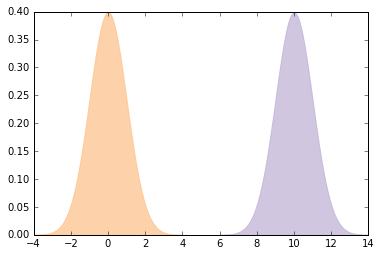

In [23]:
plot_pdfs(10);

And an interactive widget you can use to visualize what different values of $d$ mean:

In [24]:
from IPython.html.widgets import interact, fixed
from IPython.html import widgets

overlap 0.753
superiority 0.639


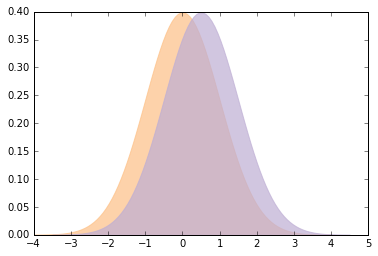

In [25]:
slider = widgets.FloatSlider(min=0, max=4, value=2)
interact(plot_pdfs, cohen_d=slider)
None

Cohen's $d$ has a few nice properties:

* Because mean and standard deviation have the same units, their ratio is dimensionless, so we can compare $d$ across different studies.

* In fields that commonly use $d$, people are calibrated to know what values should be considered big, surprising, or important.

* Given $d$ (and the assumption that the distributions are normal), you can compute overlap, superiority, and related statistics.

In summary, the best way to report effect size often depends on the audience and your goals.  There is often a tradeoff between summary statistics that have good technical properties and statistics that are meaningful to a general audience.

---
## Further reading

- Think Stats, http://greenteapress.com/thinkstats/
- ANOVA (wikipedia)    
- Bayesian Methods for Hackers

In [27]:
import pandas as pd
df = pd.read_csv('/Users/lr/Downloads/OldFeed_NewFeed.csv')

In [62]:
df.columns.tolist()

['date_ts',
 'origin_base',
 'Group',
 'scrapvipsessions',
 'prodvipsessionsfromscrap',
 'atcsessionsfromscrap',
 'storyvipsessions',
 'vipsessionsfromproductrail',
 'atcsessionsfromproductrail',
 'vipsessionsfromstoryrail',
 'vipsessionsfromscraprail',
 'scrapvipsum',
 'prodvipfromscrapsum',
 'atcfromscrapsum',
 'storyvipsum',
 'vipfromproductrailsum',
 'atccountfromproductrail',
 'vipfromstoryrailsum',
 'vipfromscraprailsum',
 'feedsessioncount111']

In [69]:
[x for x in df.columns if 'productrail' in x and 'vip' in x]

['vipsessionsfromproductrail', 'vipfromproductrailsum']

In [70]:
[x for x in df.columns if 'productrail' in x and 'atc' in x]

['atcsessionsfromproductrail', 'atccountfromproductrail']

In [64]:
[x for x in df.columns if 'scraprail' in x]

['vipsessionsfromscraprail', 'vipfromscraprailsum']

In [65]:
[x for x in df.columns if 'scrapvip' in x]

['scrapvipsessions', 'scrapvipsum']

In [66]:
[x for x in df.columns if 'storyvip' in x]

['storyvipsessions', 'storyvipsum']

In [60]:
df.isnull().sum()

date_ts origin_base    Group  scrapvipsessions  prodvipsessionsfromscrap  \
0   05/09/16   mobileapp  NewFeed              39.0                       5.0   
1   06/09/16   mobileapp  NewFeed             169.0                       8.0   
2   07/09/16   mobileapp  NewFeed             321.0                      21.0   
3   08/09/16   mobileapp  NewFeed             334.0                      28.0   
4   09/09/16   mobileapp  NewFeed             572.0                      58.0   
5   10/09/16   mobileapp  NewFeed             882.0                      79.0   
6   11/09/16   mobileapp  NewFeed             775.0                      62.0   
7   12/09/16   mobileapp  NewFeed             818.0                      79.0   
8   13/09/16   mobileapp  NewFeed             943.0                      86.0   
9   14/09/16   mobileapp  NewFeed             883.0                      88.0   
10  15/09/16   mobileapp  NewFeed             902.0                     127.0   
11  16/09/16   mobileapp  NewFeed             916.0                      95.0   
12  17/09/16   mobileapp  NewFeed             883.0                     103.0   
13  18/09/16   mobileapp  NewFeed             844.0                      91.0   
14  19/09/16   mobileapp  NewFeed             814.0                      86.0   
15  20/09/16   mobileapp  NewFeed             809.0                      74.0   
16  21/09/16   mobileapp  NewFeed             711.0                      73.0   
17  22/09/16   mobileapp  NewFeed             373.0                      36.0   
18  23/09/16   mobileapp  NewFeed             336.0                      30.0   
19  24/09/16   mobileapp  NewFeed             357.0                      46.0   
20  25/09/16   mobileapp  NewFeed             366.0                      54.0   
21  26/09/16   mobileapp  NewFeed             282.0                      22.0   
22  27/09/16   mobileapp  NewFeed             232.0                      24.0   
23  28/09/16   mobileapp  NewFeed             318.0                      26.0   
24  29/09/16   mobileapp  NewFeed             227.0                      36.0   
25  05/09/16   mobileapp  OldFeed             151.0                      11.0   
26  06/09/16   mobileapp  OldFeed             507.0                      47.0   
27  07/09/16   mobileapp  OldFeed             762.0                      79.0   
28  08/09/16   mobileapp  OldFeed             844.0                      71.0   
29  09/09/16   mobileapp  OldFeed            1645.0                     151.0   
30  10/09/16   mobileapp  OldFeed            2213.0                     192.0   
31  11/09/16   mobileapp  OldFeed            1978.0                     190.0   
32  12/09/16   mobileapp  OldFeed            2049.0                     192.0   
33  13/09/16   mobileapp  OldFeed            2328.0                     237.0   
34  14/09/16   mobileapp  OldFeed            1902.0                     174.0   
35  15/09/16   mobileapp  OldFeed            1963.0                     189.0   
36  16/09/16   mobileapp  OldFeed            1960.0                     190.0   
37  17/09/16   mobileapp  OldFeed            2041.0                     204.0   
38  18/09/16   mobileapp  OldFeed            1932.0                     201.0   
39  19/09/16   mobileapp  OldFeed            1613.0                     148.0   
40  20/09/16   mobileapp  OldFeed            1669.0                     157.0   
41  21/09/16   mobileapp  OldFeed            1406.0                     113.0   
42  22/09/16   mobileapp  OldFeed             636.0                      37.0   
43  23/09/16   mobileapp  OldFeed             579.0                      63.0   
44  24/09/16   mobileapp  OldFeed             665.0                      62.0   
45  25/09/16   mobileapp  OldFeed             762.0                      76.0   
46  26/09/16   mobileapp  OldFeed             603.0                      54.0   
47  27/09/16   mobileapp  OldFeed             497.0                      41.0   
48  28/09/16   mobileapp  OldFeed   

In [33]:
s1 = df.query("Group == 'NewFeed'").loc[:, 'scrapvipsessions']

In [34]:
s2 = df.query("Group == 'OldFeed'").loc[:, 'scrapvipsessions']

In [38]:
from scipy.stats import ttest_ind

In [59]:
s2.mean() - s1.mean()

710.9200000000001

In [40]:
ttest_ind(s1, s2)

Ttest_indResult(statistic=-4.6878691218741961, pvalue=2.313372851785643e-05)

In [52]:
df_x = (df[['Group','scrapvipsessions', 'feedsessioncount111']]
        .dropna()
        .assign(ratio = lambda x: x['scrapvipsessions']/x['feedsessioncount111'])
        .loc[:, ['Group', 'ratio']]).round(3)

In [57]:
ttest_ind(df_x.query("Group == 'NewFeed'").loc[:, 'ratio'], 
          df_x.query("Group == 'OldFeed'").loc[:, 'ratio'])

Ttest_indResult(statistic=-10.163994147505324, pvalue=1.4830681373370838e-13)